# Augmented Reality Project
##### by Alessandro Mettimano and Carlo Gemelli

### This project explores augmented reality (AR) in the context of book covers. Our goal is to superimpose an AR layer onto book covers, creating a realistic integration of virtual graphics. By employing different techniques, we aim to provide an immersive experience where viewers perceive virtual elements as part of the physical book cover

In [1]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt
#import utils
import time

#### First we import the file necessary to complete the task and show them

In [2]:
referenceFrame = 'Data/ReferenceFrame.png'
objectMask = "Data/ObjectMask.PNG"
augmentedL = 'Data/AugmentedLayer.PNG'
augmentedLMask = 'Data/AugmentedLayerMask.PNG'

In [3]:
firstFrame=cv2.imread(referenceFrame,) #reference img (first frame)
objMask=cv2.imread(objectMask ,cv2.IMREAD_GRAYSCALE) #mask of the book in the reference img

augmentedLayer=cv2.imread(augmentedL)
augmentedLayerMask=cv2.imread(augmentedLMask,cv2.IMREAD_GRAYSCALE)


Text(0.5, 1.0, 'augmentedLayerMask')

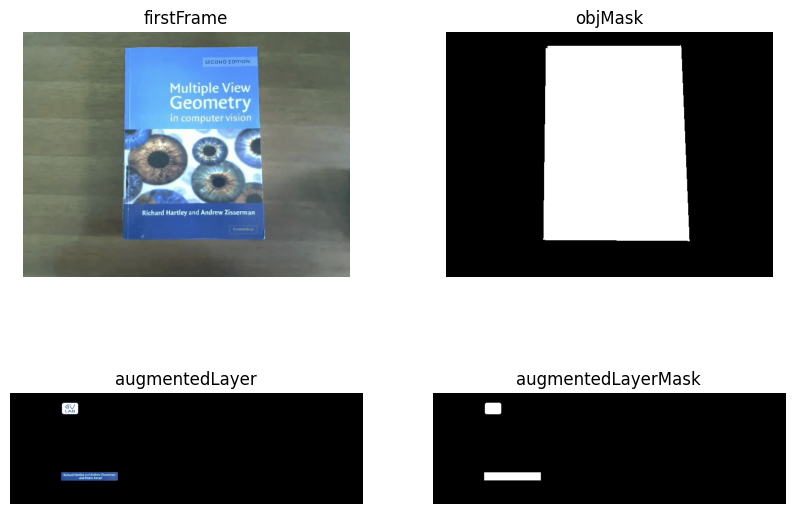

In [4]:
fig = plt.figure(figsize=(10, 7))
  
rows = 2
columns = 2
  
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(firstFrame[...,::-1])
plt.axis('off')
plt.title("firstFrame")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(objMask,cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title("objMask")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(augmentedLayer[...,::-1])
plt.axis('off')
plt.title("augmentedLayer")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(augmentedLayerMask, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title("augmentedLayerMask")


In [5]:
video=cv2.VideoCapture('Data/Multiple View.avi')

#### We define a function to keep only those points which respect Lowe's Ratio, by having the distances below 0.8

In [6]:
def get_good_points(matches,alpha) :
    goodPoints = []
    for m, n in matches:
        if m.distance < alpha * n.distance:
            goodPoints.append(m)
    return goodPoints

#### During testing we notice that, while the Augmented Layer was indeed in the correct position, from its colour you could tell that it wasn't part of the original video.

#### The following functions are useful to keep consistent the colour of the patch during the video; otherwise the patch will look fine at the beginning, but then as the video keeps changing the lighting condition, the patch doesn't appear consistent.

In [7]:
def image_HLS_medians(img,mask):
    (h, l, s) = cv2.split(img)
    return np.median(h[mask!=0]),np.median(l[mask!=0]),np.median(s[mask!=0])

#### color_harmonization_medians() takes the median of HLS values of previous frame pixels (inside the mask area) and current frame pixels (still inside the mask area). Then we substract the first median from our patch HLS values and add the second median to it.

#### we preferred using a median function rather than a mean one, since the median doesn't introduce new values but takes one from the existing ones

In [8]:
#used in Frame2Frame
def color_harmonization_medians(previous, current,target,mask):
    
    target=np.copy(target[:,:previous.shape[1]])
    
    #utils.plot_image(target,"target","BGR")
    
    previous = cv2.cvtColor(previous, cv2.COLOR_BGR2HLS).astype("float32")
    current = cv2.cvtColor(current, cv2.COLOR_BGR2HLS).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2HLS).astype("float32")
    
    
    (hMeanPrev,lMeanPrev,sMeanPrev)=image_HLS_medians(previous,mask)
    (hMeanCurr,lMeanCurr,sMeanCurr)=image_HLS_medians(current,mask)
    
    
    
    (h, l, s) = cv2.split(target)
    
    h += hMeanCurr - hMeanPrev
    l += lMeanCurr - lMeanPrev
    s += sMeanCurr - sMeanPrev
 

    h= np.clip(h, 0, 180)
    l= np.clip(l, 0, 255)
    s= np.clip(s, 0, 255)


    transferedTarget = cv2.merge([h, l, s])
    transferedTarget=cv2.cvtColor(transferedTarget.astype("uint8"), cv2.COLOR_HLS2BGR)
    transferedTarget[mask==0]=0
    
    #utils.plot_image(transferedTarget,"transferedTarget","BGR")

    
    return transferedTarget

#### color_harmonization_ppp() is used to solve the same issue as the previous function but using a different approach. For each pixel in the mask area we substract its previous HLS value and add the current HLS values.

#### In a particular scene of the video (around 00:16), when a reflection of light travers the mask area, this approach appears more consistent without disrupting the light too much, making the augmented layer stand out less almost as if it were transparent.

In [9]:
#Frame2Reference
def color_harmonization_ppp(previous,current,target,mask):
    
    target=np.copy(target[:,:reference.shape[1]])
    
    #minimum blur to have a more realistic effect
    previous=cv2.GaussianBlur(previous,(5,5),0)
    current=cv2.GaussianBlur(current,(5,5),0)

    
    #transfor into HLS
    previous = cv2.cvtColor(previous, cv2.COLOR_BGR2HLS).astype("float32")
    current = cv2.cvtColor(current, cv2.COLOR_BGR2HLS).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2HLS).astype("float32")
    
    
    #Split into H L S
    (hPrev, lPrev, sPrev) = cv2.split(previous)
    (hCurr, lCurr, sCurr) = cv2.split(current)
    (h, l, s) = cv2.split(target)
    
    #hls of mask varies by the difference of the hls between the prebious and current frame 
    h[mask!=0] += hCurr[mask!=0]-hPrev[mask!=0]
    l[mask!=0] += lCurr[mask!=0]-lPrev[mask!=0]
    s[mask!=0] += sCurr[mask!=0]-sPrev[mask!=0]


    l= np.clip(l, 0, 255)
    h= np.clip(h, 0, 180)
    s= np.clip(s, 0, 255)

    
    transferedTarget = cv2.merge([h, l, s])
    transferedTarget=cv2.cvtColor(transferedTarget.astype("uint8"), cv2.COLOR_HLS2BGR)
    transferedTarget[mask==0]=0
    
    return transferedTarget

<div style="display: flex; flex-direction: row;">
    <div style="margin-right: 10px;">
        <img src="original.png" alt="original" width="400" />
        <p style="text-align: center;">original</p>
    </div>
    <div style="margin-right: 10px;">
        <img src="interrupted_light.png" alt="colour_harmonization_medians" width="400" />
        <p style="text-align: center;">colour_harmonization_medians</p>
    </div>
    <div style="margin-right: 10px;">
        <img src="clear_light.png" alt="colour_harmonization_ppp" width="400" />
        <p style="text-align: center;">colour_harmonization_ppp</p>
    </div>
</div>

### Overall we preferred using the "ppp" function on the F2R approach, while the "medians" one on the F2F method. 
### The reason is that while the "ppp" seems to provide a more consistent look through different light conditions, it needs a stable superimposition otherwise it will highlight any difference that will occour between the augmented layer and the underlying frame and F2F sometimes cannot provide such requirement.

### We also noticed the showing a thin black contour around the augmented layer. It occours since the pixels deleted from the background video are not fully covered by the augmented layer.



<div style="margin-right: 10px;">
        <img src="black_contours.png" alt="original" width="350" />
        <p style="text-align: center;">Frame with black contours</p>
    </div>
    
### By adding the pixel values found in the original video in the augmented one, found through erosion, we managed to create a more realistic image. This is implemented in the following fix_superimpose() function that does also the super imposition.

In [10]:
def fix_superimpose(aLMask_warp, kernel_size, frame, aL_warp):
    kernel=np.ones((kernel_size,kernel_size))
    aLMask_warp_eroded=cv2.erode(aLMask_warp, kernel, iterations=1)
    #superimposition
    aR_frame=cv2.copyTo(dst=frame,src=aL_warp,mask=aLMask_warp_eroded)
    return aR_frame

### To better track performances we show fps counter on screen but it won't be saved on video.

In [11]:
def getFPS(prev_frame_time):
    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time
    fps = int(fps)
    fps = str(fps)
    return fps, prev_frame_time

### To apply the augmented layer we need to find correspondencies between a reference and the current frame played on video. We explored two main approaches: Frame2Reference and Frame2Frame.

### F2R takes the first frame as a reference for the whole video duration, comparing the current frame to that still image. 

### We used different kind of detector, descriptors and matching operators. First we introduce SIFT (Scale Invariant Feature Transform). Used both as detector and descriptor, it is able to find keypoints that are invariant to scale, rotation and partial occlusion.

### These are the keypoints detected by SIFT:

<div style="margin-right: 10px;">
        <img src="sift kp.png" alt="original" width="350" />
        <p style="text-align: center;">SIFT KP</p>
    </div>

### We show the matching done by SIFT as detector and descriptor:

<div style="margin-right: 10px;">
        <img src="sift matching.png" alt="original" width="700" />
        <p style="text-align: center;">Sift Matching</p>
    </div>


# F2R - SIFT

In [12]:
video=cv2.VideoCapture('Data/Multiple View.avi')
#original_fps = video.get(cv2.CAP_PROP_FPS)

referenceBGR=np.copy(firstFrame)
reference=cv2.cvtColor(firstFrame,cv2.COLOR_BGR2GRAY)
aL=np.copy(augmentedLayer)
aLMask=augmentedLayerMask[:,:reference.shape[1]]

# parameters for fps counter
prev_frame_time = 0
new_frame_time = 0
font=cv2.FONT_HERSHEY_SIMPLEX


# Feature extraction from the referece image
sift = cv2.SIFT_create()
kp_reference, desc_reference = sift.detectAndCompute(reference,objMask)

# setting the flann based feature matcher
index_params = dict(algorithm=0, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)

writer = cv2.VideoWriter("F2R_SIFT-SIFT.avi",cv2.VideoWriter_fourcc(*"MJPG"), 15,(640,480))


while True:
    
    #getting the frame
    ret,frame = video.read()
   
    # if video finished or no Video Input
    if not ret:
        break
    
    gray_frame= cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # image used for feature matching
    kp_gray_frame ,desc_gray_frame = sift.detectAndCompute(gray_frame, objMask)
    
    #getting matches between reference and the frame
    matches=flann.knnMatch(desc_reference,desc_gray_frame,k=2)
    
    #cutting out the matched points that aren't good
    good_points = get_good_points(matches,0.8)
     
    #calcutation of the transformation matrix between reference image and frame
    reference_pts = np.float32([kp_reference[m.queryIdx].pt for m in good_points]).reshape(-1,1,2)
    gray_frame_pts = np.float32([kp_gray_frame[m.trainIdx].pt for m in good_points]).reshape(-1,1,2)
    
    matrix, mask = cv2.findHomography(reference_pts, gray_frame_pts, cv2.RANSAC, 2.0)
    
    
    #getting the warped augmented layer    
    aL_warp= cv2.warpPerspective(aL,matrix,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    
    # color harmonization to make it look more realistic
    # warp the refence image to get the same book position of the one in the current frame
    referenceBGR_warp=cv2.warpPerspective(referenceBGR,matrix,(objMask.shape[1],objMask.shape[0]),flags=cv2.INTER_LINEAR)
    aLMask_warp=cv2.warpPerspective(aLMask,matrix,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    aLMask_warp = cv2.threshold(aLMask_warp, 127, 255, cv2.THRESH_BINARY)[1]

    aL_warp=color_harmonization_ppp(referenceBGR_warp, frame ,aL_warp,aLMask_warp)

    
    
    #superimposing the frame with the augmented layer
    
    aR_frame=fix_superimpose(aLMask_warp, 3, frame, aL_warp)

    writer.write(aR_frame)

        
    #fps counter
    fps, prev_frame_time = getFPS(prev_frame_time)
    cv2.putText(aR_frame,"fps:"+fps, (7, 30),font, 1, (0, 255, 0), 1, cv2.LINE_AA)
    
    cv2.imshow("ar_frame",aR_frame)
    #draw real time kp
    #imgKp = cv2.drawKeypoints(reference,kp_reference,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #cv2.imshow("kp", imgKp)
    

    key=cv2.waitKey(1)
    if key==27 :
        break

writer.release()
video.release()
cv2.destroyAllWindows()
    
    

### The Frame2Frame approach, on the other hand, doesn't use just the first frame as reference; instead for each frame it takes the previous one as reference. 

### We noticed that by changing the reference continously, the error in each frame would risk to add up and ruin the Augmented Layer position in the current frame. So, to make it more robust, we empirically decided to lower Lowe's ratio from 0.8 to 0.3. 

# F2F - SIFT

In [25]:
video=cv2.VideoCapture('Data/Multiple View.avi')

reference=cv2.cvtColor(firstFrame,cv2.COLOR_BGR2GRAY)
aL=np.copy(augmentedLayer)
aLMask=augmentedLayerMask[:,:reference.shape[1]]

# parameters for fps counter
prev_frame_time = 0
new_frame_time = 0
font=cv2.FONT_HERSHEY_SIMPLEX

# Feature extraction from the referece image
sift = cv2.SIFT_create()
kp_reference, desc_reference = sift.detectAndCompute(reference,objMask)
# setting the flann based feature matcher
index_params = dict(algorithm=0, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)

writer = cv2.VideoWriter("F2F_SIFT-SIFT.avi",cv2.VideoWriter_fourcc(*"MJPG"), 15,(640,480))


#transformation matrix
M=[[1,0,0],[0,1,0],[0,0,1]] #at start is the identity
count=0
while True:
    #getting the frame
    ret,frame = video.read()
    count+=1
    # if video finished or no Video Input
    if not ret:
        break
    frame_cpy=np.copy(frame)
    gray_frame= cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # image used for feature matching
   
    kp_gray_frame ,desc_gray_frame = sift.detectAndCompute(gray_frame, None)
    
    #getting matches between reference and the frame
    matches=flann.knnMatch(desc_reference,desc_gray_frame,k=2)
    
    #cutting out the matched points that aren't good
    #usign a parameter significantly lower than the lowes' one because in this case errors adds up
    good_points = get_good_points(matches,0.3) 
        
    #calcutation of the transformation matrix between reference image and frame
    reference_pts = np.float32([kp_reference[m.queryIdx].pt for m in good_points]).reshape(-1,1,2)
    gray_frame_pts = np.float32([kp_gray_frame[m.trainIdx].pt for m in good_points]).reshape(-1,1,2)
    
    
    matrix, mask = cv2.findHomography(reference_pts, gray_frame_pts, cv2.RANSAC, 5.0)    
    
    #getting the transfotmation matrix between the first frame and the frame
    
    #defining X as the transoformation matrix from the first frame and the reference image
    #and Y as the transformation matrix from the reference image and the current frame
    #the transformation matrix between the first frame and the current frame is the dot product between Y and X
    
    M=np.dot(matrix,M)
    
    #getting the warped augmented layer
    aL_warp= cv2.warpPerspective(aL,M,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    
    # color harmonization to make it look more realistic
    aLMask_warp=cv2.warpPerspective(aLMask,M,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    aLMask_warp = cv2.threshold(aLMask_warp, 127, 255, cv2.THRESH_BINARY)[1]

    firstFrame_warp=cv2.warpPerspective(firstFrame,M,(objMask.shape[1],objMask.shape[0]),flags=cv2.INTER_LINEAR)
    objMask_warp=cv2.warpPerspective(objMask,M,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    objMask_warp = cv2.threshold(objMask_warp, 127, 255, cv2.THRESH_BINARY)[1]
    
    #aL_warp=color_harmonization_medians(firstFrame_warp, frame ,aL_warp,aLMask_warp)
    aL_warp=color_harmonization_ppp(firstFrame_warp, frame ,aL_warp,aLMask_warp)

    #superimposing the frame with the augmented layer
    
    aR_frame=fix_superimpose(aLMask_warp, 3, frame, aL_warp)
    
    writer.write(aR_frame)

    
    #fps counter
    fps, prev_frame_time = getFPS(prev_frame_time)
    cv2.putText(aR_frame,"fps:"+fps, (7, 30),font, 1, (0, 255, 0), 1, cv2.LINE_AA)
    

    #settign the current frame as the reference frame
    reference=gray_frame
    kp_reference, desc_reference = sift.detectAndCompute(reference,objMask_warp)    
    
    cv2.imshow("ar_frame",aR_frame)
    #draw real time matches
    #img3 = cv2.drawMatches(reference,kp_reference,gray_frame,kp_gray_frame, good_points, None, flags=2)
    #cv2.imshow("matching",img3)
    
    key=cv2.waitKey(1)
    if key==27 :
        break

writer.release()

video.release()
cv2.destroyAllWindows()

### Since SIFT provides more robust keypoints, it is expected to have more computational load on the machine. Based on the previous snippets of code and the resulting videos, we can see how F2R runs with an average of 7 fps while F2F has one of 5 fps (on this particular machine). 

### This cause the videos to appear slower than the original at runtime (since it runs at 15 fps), but then they are saved at normal speed.

### So, with our machines, it appears unfit to run a realistic real-time superimposition using SIFT.

### Then we use Shi-Tomasi. This detector is ideal to find "good feature to track", where corners presents significant changes in intensity along two perpendicular directions. It is generally faster than SIFT but it doesn't take into account scale variance. This would make it more adapt to real time detection such as our case.

### As descriptor we keep using SIFT.

### These are the keypoints detected by Shi-Tomasi:

<div style="margin-right: 10px;">
        <img src="shi-tomasi kp.png" alt="original" width="350" />
        <p style="text-align: center;">Shi-Tomasi KP</p>
    </div>

### We show the matching done Shi-Tomasi as detector and SIFT as descriptor:

<div style="margin-right: 10px;">
        <img src="shi-tomasi matching.png" alt="original" width="700" />
        <p style="text-align: center;">Shi-Tomasi / SIFT Matching</p>
    </div>

### It appears that some keypoints are matched incorrectly from across different area of the images (as highlighted by the diagonal lines)

# F2R shi-tomasi / SIFT

In [15]:
video=cv2.VideoCapture('Data/Multiple View.avi')


referenceBGR=np.copy(firstFrame)
reference=cv2.cvtColor(firstFrame,cv2.COLOR_BGR2GRAY)
aL=np.copy(augmentedLayer)
aLMask=augmentedLayerMask[:,:reference.shape[1]]

# parameters for fps counter
prev_frame_time = 0
new_frame_time = 0
font=cv2.FONT_HERSHEY_SIMPLEX

# Feature extraction from the referece image
sift = cv2.SIFT_create()
kp_reference=cv2.goodFeaturesToTrack(reference,200,0.1,5,mask=objMask)
kp_reference = [cv2.KeyPoint(y=k[0][1], x=k[0][0], size= 1) for k in kp_reference]
kp_reference, desc_reference = sift.compute(reference,kp_reference)
# setting the flann based feature matcher
index_params = dict(algorithm=0, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)

writer = cv2.VideoWriter("F2R_shi-tomasi-SIFT.avi",cv2.VideoWriter_fourcc(*"MJPG"), 15,(640,480))



while True:
    #getting the frame
    ret,frame = video.read()
   
    # if video finished or no Video Input
    if not ret:
        break

    frame_cpy=np.copy(frame)
    gray_frame= cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # image used for feature matching
   
    kp_gray_frame=cv2.goodFeaturesToTrack(gray_frame,maxCorners=200,qualityLevel=0.1, minDistance=5)
    kp_gray_frame=[cv2.KeyPoint(y=k[0][1], x=k[0][0], size= 1) for k in kp_gray_frame]
    kp_gray_frame ,desc_gray_frame = sift.compute(gray_frame, kp_gray_frame)
    
    #getting matches between reference and the frame
    matches=flann.knnMatch(desc_reference,desc_gray_frame,k=2)
    
    #cutting out the matched points that aren't good
    #usign a parameter significantly lower than the lowes' one because in this case errors adds up
    good_points = get_good_points(matches,0.8) 
        
    #calcutation of the transformation matrix between reference image and frame
    reference_pts = np.float32([kp_reference[m.queryIdx].pt for m in good_points]).reshape(-1,1,2)
    gray_frame_pts = np.float32([kp_gray_frame[m.trainIdx].pt for m in good_points]).reshape(-1,1,2)
    
    
    matrix, mask = cv2.findHomography(reference_pts, gray_frame_pts, cv2.RANSAC, 5.0)
    
    
    #getting the warped augmented layer    
    aL_warp= cv2.warpPerspective(aL,matrix,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    
    # color harmonization to make it look more realistic
    referenceBGR_warp=cv2.warpPerspective(referenceBGR,matrix,(objMask.shape[1],objMask.shape[0]),flags=cv2.INTER_LINEAR)
    aLMask_warp=cv2.warpPerspective(aLMask,matrix,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    aLMask_warp = cv2.threshold(aLMask_warp, 127, 255, cv2.THRESH_BINARY)[1]

    aL_warp=color_harmonization_ppp(referenceBGR_warp, frame ,aL_warp,aLMask_warp)

    
    
    #superimposing the frame with the augmented layer
    
    aR_frame=fix_superimpose(aLMask_warp, 3, frame, aL_warp)
    
    writer.write(aR_frame)

    
    #fps counter
    fps, prev_frame_time = getFPS(prev_frame_time)
    cv2.putText(aR_frame,"fps:"+fps, (7, 30),font, 1, (0, 255, 0), 1, cv2.LINE_AA)

    cv2.imshow("ar_frame",aR_frame)


    key=cv2.waitKey(1)
    if key==27 :
        break

writer.release()

video.release()
cv2.destroyAllWindows()

# F2F shi-tomasi / SIFT

In [16]:

video=cv2.VideoCapture('Data/Multiple View.avi')

reference=cv2.cvtColor(firstFrame,cv2.COLOR_BGR2GRAY)
aL=np.copy(augmentedLayer)
aLMask=augmentedLayerMask[:,:reference.shape[1]]

# parameters for fps counter
prev_frame_time = 0
new_frame_time = 0
font=cv2.FONT_HERSHEY_SIMPLEX

# Feature extraction from the referece image
sift = cv2.SIFT_create()

kp_reference=cv2.goodFeaturesToTrack(reference,300,0.1,5,mask=objMask)
kp_reference = [cv2.KeyPoint(y=k[0][1], x=k[0][0], size= 1) for k in kp_reference]
kp_reference, desc_reference = sift.compute(reference,kp_reference)

# setting the flann based feature matcher
index_params = dict(algorithm=0, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)

writer = cv2.VideoWriter("F2F_shi-tomasi-SIFT.avi",cv2.VideoWriter_fourcc(*"MJPG"), 15,(640,480))


#transformation matrix
M=[[1,0,0],[0,1,0],[0,0,1]] #at start is the identity

while True:
    #getting the frame
    ret,frame = video.read()
   
    # if video finished or no Video Input
    if not ret:
        break
    
    frame_cpy=np.copy(frame)
    gray_frame= cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # image used for feature matching
   
    kp_gray_frame=cv2.goodFeaturesToTrack(gray_frame,maxCorners=300,qualityLevel=0.1, minDistance=5)
    kp_gray_frame=[cv2.KeyPoint(y=k[0][1], x=k[0][0], size= 1) for k in kp_gray_frame]
    kp_gray_frame ,desc_gray_frame = sift.compute(gray_frame, kp_gray_frame)
    
    #getting matches between reference and the frame
    matches=flann.knnMatch(desc_reference,desc_gray_frame,k=2)    
    good_points = get_good_points(matches,0.8) 
    #we keep 0.8 as Lowe's ratio since Shi-Tomasi likely finds lots of keypoints on the authors names' characters
    #a smaller Lowe's ratio would cause the detector to ignore most keypoints

        
    #calcutation of the transformation matrix between reference image and frame
    reference_pts = np.float32([kp_reference[m.queryIdx].pt for m in good_points]).reshape(-1,1,2)
    gray_frame_pts = np.float32([kp_gray_frame[m.trainIdx].pt for m in good_points]).reshape(-1,1,2)
    
    
    matrix, mask = cv2.findHomography(reference_pts, gray_frame_pts, cv2.RANSAC, 3.0)
    
    
    #getting the transfotmation matrix between the first frame and the frame
    
    #defining X as the transoformation matrix from the first frame and the reference image
    #and Y as the transformation matrix from the reference image and the current frame
    #the transformation matrix between the first frame and the current frame is the dot product between Y and X
    
    M=np.dot(matrix,M)
    
    #getting the warped augmented layer
    aL_warp= cv2.warpPerspective(aL,M,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    
    # color harmonization to make it look more realistic
    aLMask_warp=cv2.warpPerspective(aLMask,M,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    aLMask_warp = cv2.threshold(aLMask_warp, 127, 255, cv2.THRESH_BINARY)[1]

    firstFrame_warp=cv2.warpPerspective(firstFrame,M,(objMask.shape[1],objMask.shape[0]),flags=cv2.INTER_LINEAR)
    objMask_warp=cv2.warpPerspective(objMask,M,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    objMask_warp = cv2.threshold(objMask_warp, 127, 255, cv2.THRESH_BINARY)[1]
    
    aL_warp=color_harmonization_medians(firstFrame_warp, frame ,aL_warp,aLMask_warp)

    #superimposing the frame with the augmented layer
    
    aR_frame=fix_superimpose(aLMask_warp, 3, frame, aL_warp)
    
    writer.write(aR_frame)

    
    #fps counter
    fps, prev_frame_time = getFPS(prev_frame_time)
    cv2.putText(aR_frame,"fps:"+fps, (7, 30),font, 1, (0, 255, 0), 1, cv2.LINE_AA)

    #settign the current frame as the reference frame
    reference=gray_frame
    kp_reference=cv2.goodFeaturesToTrack(reference,300,0.1,5,mask=objMask_warp)
    kp_reference = [cv2.KeyPoint(y=k[0][1], x=k[0][0],size= 1) for k in kp_reference]
    kp_reference, desc_reference = sift.compute(reference,kp_reference)

    cv2.imshow("ar_frame",aR_frame)
    
    #draw real time matches
    #img3 = cv2.drawMatches(reference,kp_reference,gray_frame,kp_gray_frame, good_points, None, flags=2)
    #cv2.imshow("matching",img3)
    
    key=cv2.waitKey(1)
    if key==27 :
        break

writer.release()
video.release()
cv2.destroyAllWindows()

### With Shi-Tomasi as detector and SIFT as descriptor it appears that both the F2R and F2F can keep up with the original fps speed at runtime. We believe that this solution can fit out criteria and be adapt to a real-time superimposition, since in this specific video we don't have significant scale variances but the keypoints found by Shi-Tomasi are consistent through light changes. 

### We then tried using Shi-Tomasi as detector and BRIEF as descriptor. 

### Even though using SIFT just as a descriptor proved to be a feasable solution, we tried a different combination for even lighter computional load.

### We show the matching done by Shi-Tomasi as detector and Brief as descriptor:

<div style="margin-right: 10px;">
        <img src="matching brief.png" alt="original" width="700" />
        <p style="text-align: center;">Shi-Tomasi / Brief Matching</p>
    </div>

### While it doesn't show clear mismatching with diagonal lines (unlike the previous method), at a closer look we can see how some matches are wrong. For instance in the upper-right corner of the book where it's printed "SECOND EDITION" the orange line shows a mismatch.

## F2R Shi-Tomasi/BRIEF

In [34]:
video=cv2.VideoCapture('Data/Multiple View.avi')


referenceBGR=np.copy(firstFrame)
reference=cv2.cvtColor(firstFrame,cv2.COLOR_BGR2GRAY)
aL=np.copy(augmentedLayer)
aLMask=augmentedLayerMask[:,:reference.shape[1]]

# parameters for fps counter
prev_frame_time = 0
new_frame_time = 0
font=cv2.FONT_HERSHEY_SIMPLEX

# Feature extraction from the referece image
brief=cv2.xfeatures2d.BriefDescriptorExtractor_create()
kp_reference=cv2.goodFeaturesToTrack(reference,200,0.1,5,mask=objMask)
kp_reference = [cv2.KeyPoint(y=k[0][1], x=k[0][0], size= 1) for k in kp_reference]
kp_reference, desc_reference = brief.compute(reference,kp_reference)
# setting the BF based feature matcher
#
#FLANN_INDEX_LSH = 6
#index_params= dict(algorithm = FLANN_INDEX_LSH,
 #table_number = 12, # 12
 #key_size = 20, # 20
 #multi_probe_level = 2) #2
#search_params = dict()
#matcher = cv2.FlannBasedMatcher(index_params, search_params)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

writer = cv2.VideoWriter("F2R_shi-tomasi-BRIEF.avi",cv2.VideoWriter_fourcc(*"MJPG"), 15,(640,480))


while True:
    #getting the frame
    ret,frame = video.read()
   
    # if video finished or no Video Input
    if not ret:
        break

    frame_cpy=np.copy(frame)
    gray_frame= cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # image used for feature matching
   
    kp_gray_frame=cv2.goodFeaturesToTrack(gray_frame,maxCorners=200,qualityLevel=0.1, minDistance=5)
    kp_gray_frame=[cv2.KeyPoint(y=k[0][1], x=k[0][0], size= 1) for k in kp_gray_frame]
    kp_gray_frame ,desc_gray_frame = brief.compute(gray_frame, kp_gray_frame)
    
    #getting matches between reference and the frame
    matches=matcher.match(desc_reference,desc_gray_frame)
    
    #calcutation of the transformation matrix between reference image and frame
    reference_pts = np.float32([kp_reference[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    gray_frame_pts = np.float32([kp_gray_frame[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    
    
    matrix, mask = cv2.findHomography(reference_pts, gray_frame_pts, cv2.RANSAC, 5.0)
    
    
    #getting the warped augmented layer    
    aL_warp= cv2.warpPerspective(aL,matrix,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    
    # color harmonization to make it look more realistic
    referenceBGR_warp=cv2.warpPerspective(referenceBGR,matrix,(objMask.shape[1],objMask.shape[0]),flags=cv2.INTER_LINEAR)
    aLMask_warp=cv2.warpPerspective(aLMask,matrix,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    aLMask_warp = cv2.threshold(aLMask_warp, 127, 255, cv2.THRESH_BINARY)[1]

    aL_warp=color_harmonization_ppp(referenceBGR_warp, frame ,aL_warp,aLMask_warp)

    
    
    #superimposing the frame with the augmented layer
    
    aR_frame=fix_superimpose(aLMask_warp, 3, frame, aL_warp)
    writer.write(aR_frame)
    
    #fps counter
    fps, prev_frame_time = getFPS(prev_frame_time)
    cv2.putText(aR_frame,"fps:"+fps, (7, 30),font, 1, (0, 255, 0), 1, cv2.LINE_AA)

    cv2.imshow("ar_frame",aR_frame)

    key=cv2.waitKey(1)
    if key==27 :
        break
writer.release()
video.release()
cv2.destroyAllWindows()

## F2F Shi-Tomasi/Brief

In [18]:
video=cv2.VideoCapture('Data/Multiple View.avi')

reference=cv2.cvtColor(firstFrame,cv2.COLOR_BGR2GRAY)
aL=np.copy(augmentedLayer)
aLMask=augmentedLayerMask[:,:reference.shape[1]]

# parameters for fps counter
prev_frame_time = 0
new_frame_time = 0
font=cv2.FONT_HERSHEY_SIMPLEX

# Feature extraction from the referece image
brief=cv2.xfeatures2d.BriefDescriptorExtractor_create()
kp_reference=cv2.goodFeaturesToTrack(reference,200,0.1,5,mask=objMask)
kp_reference = [cv2.KeyPoint(y=k[0][1], x=k[0][0], size= 1) for k in kp_reference]
kp_reference, desc_reference = brief.compute(reference,kp_reference)
# setting the BF based feature matcher
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

writer = cv2.VideoWriter("F2F_shi-tomasi-BRIEF.avi",cv2.VideoWriter_fourcc(*"MJPG"), 15,(640,480))


#transformation matrix
M=[[1,0,0],[0,1,0],[0,0,1]] #at start is the identity

while True:
    #getting the frame
    ret,frame = video.read()
   
    # if video finished or no Video Input
    if not ret:
        break
    
    frame_cpy=np.copy(frame)
    gray_frame= cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # image used for feature matching
   
    kp_gray_frame=cv2.goodFeaturesToTrack(gray_frame,maxCorners=200,qualityLevel=0.1, minDistance=5)
    kp_gray_frame=[cv2.KeyPoint(y=k[0][1], x=k[0][0], size= 1) for k in kp_gray_frame]
    kp_gray_frame ,desc_gray_frame = brief.compute(gray_frame, kp_gray_frame)
    
    #getting matches between reference and the frame
    matches=matcher.match(desc_reference,desc_gray_frame)     
        
    #calcutation of the transformation matrix between reference image and frame
    reference_pts = np.float32([kp_reference[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    gray_frame_pts = np.float32([kp_gray_frame[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    
    
    matrix, mask = cv2.findHomography(reference_pts, gray_frame_pts, cv2.RANSAC, 3.0)    
    
    #getting the transfotmation matrix between the first frame and the frame
    
    #defining X as the transoformation matrix from the first frame and the reference image
    #and Y as the transformation matrix from the reference image and the current frame
    #the transformation matrix between the first frame and the current frame is the dot product between Y and X
    
    M=np.dot(matrix,M)
    
    #getting the warped augmented layer
    aL_warp= cv2.warpPerspective(aL,M,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    
    # color harmonization to make it look more realistic
    aLMask_warp=cv2.warpPerspective(aLMask,M,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    aLMask_warp = cv2.threshold(aLMask_warp, 127, 255, cv2.THRESH_BINARY)[1]

    firstFrame_warp=cv2.warpPerspective(firstFrame,M,(objMask.shape[1],objMask.shape[0]),flags=cv2.INTER_LINEAR)
    objMask_warp=cv2.warpPerspective(objMask,M,(frame.shape[1],frame.shape[0]),flags=cv2.INTER_LINEAR)
    objMask_warp = cv2.threshold(objMask_warp, 127, 255, cv2.THRESH_BINARY)[1]
    
    aL_warp=color_harmonization_medians(firstFrame_warp, frame ,aL_warp,aLMask_warp)

    #superimposing the frame with the augmented layer
       
    aR_frame=fix_superimpose(aLMask_warp, 3, frame, aL_warp)
    
    writer.write(aR_frame)

    
    #fps counter
    fps, prev_frame_time = getFPS(prev_frame_time)
    cv2.putText(aR_frame,"fps:"+fps, (7, 30),font, 1, (0, 255, 0), 1, cv2.LINE_AA)

    #settign the current frame as the reference frame
    reference=gray_frame
    kp_reference=cv2.goodFeaturesToTrack(reference,200,0.1,5,mask=objMask_warp)
    kp_reference = [cv2.KeyPoint(y=k[0][1], x=k[0][0],size= 1) for k in kp_reference]
    kp_reference, desc_reference = brief.compute(reference,kp_reference)

    cv2.imshow("ar_frame",aR_frame)
    #show real time matching
    #img3 = cv2.drawMatches(reference,kp_reference,gray_frame,kp_gray_frame, matches, None, flags=2)
    #cv2.imshow("matching",img3)
    
    key=cv2.waitKey(1)
    if key==27 :
        break

writer.release()
video.release()
cv2.destroyAllWindows()

### We were able to further improve the speed of the video rendering, with the expected trade-off in quality.

# Conclusions

### We experimented with different techinques and approaches:

### SIFT (as descriptor and detector) proved to be consistent but unfit to lower-end machines. While the keypoints were stable, the computational load appears to be kind of heavy and risks of providing a unrealistic and slowed real-time AR video.

### Using Shi-Tomasi as detector and SIFT as descriptor resulted in a realistic real-time video without a significant worsening on the super imposition quality. Overall, in this specific case, a light detector such as Shi-Tomasi proved more than fit to satisfy our requirements.

### Finally, we implemented a solution even lighter with Shi-Tomasi as detector and BRIEF as descriptor. This one was indeed computationally competitive, but the quality of the super imposition of the augmented layer was worse. For this project we find this trade-off not worth it but still relevant for lower end machines.

### By taking into consideration the differences between Frame2Reference and Frame2Frame, in the first one the keypoints matching is less accurate as the video shows more diverse views from the first frame (taken as reference), while the F2F seems to provide a better matching by taking the previous frame as reference.

### On the other hand, by changing reference consistently and computing the homography by multiplying the previous ones, we noticed in F2F a possible error cumulation that resulted in a "drift" of the augmented layer over the original video. While minimal, there is also a slightly higher computational load compared to the F2R.

### For this specific task we conclude that the combination of Shi-Tomasi (detector) and SIFT (descriptor) applied to a Frame2Reference method is the most realistic one with the best trade-off between quality and performance.